# Holly's Data Science Capstone Projects

### I want to find a good location for my mobile coffee cart!  It has a license for parks and public areas.  I want to find a park with a nearby public toilet, which data suggests WOULD be a good location for a coffee shop, but currently doesn't have many.

## Part 1: Install Packages

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import geopy.distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.lines as mlines

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as sm

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Part 2: Import Data 

### Dataset 1: Locations of public toilets in Edinburgh

In [2]:
df=pd.read_csv("https://data.edinburghopendata.info/dataset/2a8a1335-06be-4766-96f8-07638610f1bf/resource/36ead7e6-8234-4317-a73a-5575c1da64f8/download/directoryexport61.csv")
df = df[['Toilet','Location']]
df.rename(columns={'Location':'Toilet_Location'},inplace=True)
print(df.shape)
df.head()

(98, 2)


,Toilet,Toilet_Location
0,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895"
1,Bath Street Public Toilet,"55.952976,-3.114088"
2,Bingham Community Centre,"55.9403279768,-3.12461868252"
3,Blackhall Library,"55.9616673126,-3.2611578066"
4,Braid Hills Golf Course,"55.9163063539,-3.20571551039"


### Dataset 2: Locations of public park's play areas

In [3]:
df2=pd.read_csv("https://data.edinburghopendata.info/dataset/a22a4332-b73f-4477-834c-76d22ed8f993/resource/0e3b0a25-5bae-45b0-beb4-e63178305741/download/directoryexport60.csv")
df2 = df2[['Site','Location map']]
df2.rename(columns={'Location map':'Site_Location'},inplace=True)
print(df2.shape)
df2.head()

(155, 2)


,Site,Site_Location
0,Admirality Street,"55.97615152741767,-3.1789112091064453"
1,Allison Park,"55.95463010760622,-3.410053253173828"
2,Ardshiel Avenue (Torrence Park),"55.953523,-3.29278"
3,Bailie Place (Rear Nos. 1-5),"55.943291,-3.111828"
4,Balgreen Park,"55.94174996445649,-3.2571029663085938"


### We only want to keep the park play areas which have nearby toilets.  To identify these, I will do a many-to-many merge, drop the pairs with too large a distance between, and then keep only the unique park play areas remaining.

In [4]:
# First, let's drop any na data
df=df.dropna()
df.reset_index(drop=True)
df2=df2.dropna()
df2.reset_index(drop=True)

# Next, let's check the size of each dataframe so we can verify the merge worked well
print('The first dataset has {} rows'.format(df.shape[0]))
print('The second dataset has {} rows'.format(df2.shape[0]))
print('The merged dataset should have {} rows'.format(df.shape[0]*df2.shape[0]))

The first dataset has 97 rows
The second dataset has 154 rows
The merged dataset should have 14938 rows


In [5]:
## We have to create a temporary variable with the value 1 for all rows, 
## as merge won't let you join without a join key
df['tmp'] = 1
df2['tmp'] = 1
df=pd.merge(df,df2, on=['tmp'])
df=df.drop('tmp', axis=1)
print('The merged dataset has {} rows'.format(df.shape[0]))
df.head()

The merged dataset has 14938 rows


,Toilet,Toilet_Location,Site,Site_Location
0,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895",Admirality Street,"55.97615152741767,-3.1789112091064453"
1,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895",Allison Park,"55.95463010760622,-3.410053253173828"
2,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895",Ardshiel Avenue (Torrence Park),"55.953523,-3.29278"
3,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895",Bailie Place (Rear Nos. 1-5),"55.943291,-3.111828"
4,Ainslie Park Leisure Centre,"55.972014831,-3.2304253895",Balgreen Park,"55.94174996445649,-3.2571029663085938"


In [6]:
df['nearest_toilet_km'] = round(df.apply(lambda row: geopy.distance.distance(row['Toilet_Location'], 
                                                                         row['Site_Location']).km, 
                                     axis=1),1)
# Let's drop those with distance more than 500m
df=df[df['nearest_toilet_km']<=0.5]
print(df.shape)

(161, 5)


(83, 4)
0.2903614457831325


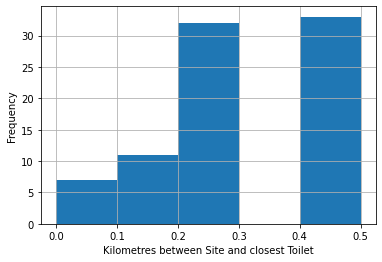

In [7]:
#Mean closest distance from remaining sites
plot_df=df.sort_values(['Site','nearest_toilet_km']).groupby('Site', axis=0).first()
print(plot_df.shape)
print(plot_df['nearest_toilet_km'].mean(axis=0))
x=plot_df['nearest_toilet_km'].hist(bins=5)
x.set_xlabel("Kilometres between Site and closest Toilet")
x.set_ylabel("Frequency")
x

In [48]:
# Make a df of the playareas, keeping only unique sites (with a toilet within 500m)
df_playareas=plot_df[['Site_Location']]
df_playareas = df_playareas.groupby('Site', axis=0).first()

# Split the coordinates into latitude and longitude, as the next function will need
df_playareas[['Latitude','Longitude']]=df_playareas['Site_Location'].str.split(',', expand=True)
df_playareas=df_playareas.drop('Site_Location', axis=1)
df_playareas.head()

,Latitude,Longitude
Site,,
Admirality Street,55.97615152741767,-3.1789112091064453
Allison Park,55.95463010760622,-3.410053253173828
Ardshiel Avenue (Torrence Park),55.953523,-3.29278
Bailie Place (Rear Nos. 1-5),55.943291,-3.111828
Balgreen Park,55.94174996445649,-3.2571029663085938


### Dataset 3: Locations of Venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id=PBIUIPDGY42UF5KTZOLDQI1DDLGCSYDTTC54CN5QVSI4KV0L&client_secret=KZ4S0TCURB2O2MP4AOQTC3CBXKTE54KG1VCVKPHHS5EH4IYB&v=20180605&ll={},{}&radius=1000&limit=50'.format(
            lat, lng)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Site',
                                 'Location', 
                                 'Venue Latitude', 
                                 'Venue Longitude', 
                                 'Category']                             
    return(nearby_venues)

In [11]:
venues = getNearbyVenues(names=df_playareas.index,
                                   latitudes=df_playareas['Latitude'],
                                   longitudes=df_playareas['Longitude'])
venues.head()

Admirality Street
Allison Park 
Ardshiel Avenue (Torrence Park)
Bailie Place (Rear Nos. 1-5)
Balgreen Park
Bingham Park
Bloomiehall Park
Boswall/Royston Mains Gardens
Broughton Road
Brown Street, Pleasance
Burdiehouse Burn Valley Park 
Calder Park play area
Clermiston Park
Craigentinny Ball Court
Craigpark Crescent play area
Cramond Walled Garden
Dolphins Gardens West
Drum Park
Dumbeg Park, off Harvesters Way
Dumbiedykes
East Pilton Park
Fairmilehead Park
Falcon Road/Park
Ferniehill Community Park
Glendevon Park
Gorgie/Dalry Community Park
Gracemount House Drive
Gracemount Leisure Centre
Granton Crescent
Granton Mains East
Greenacre, off Harvesters Way
Harrison Park East
Henderson Gardens
Huntershall Park
Inch Park
Inchcolm Terrace
Inverleith Park 
Jewel Park
Joppa Quarry Park
Keddie Gardens
King George V Park (Currie) 
King George V Park (Eyre Place) 
Kirkliston Sports Centre
Loganlea Avenue
Magdalene Community Centre
Magnet Playarea (East Meadows)
Marytree House
Meadows (West)
Megget

,Site,Location,Venue Latitude,Venue Longitude,Category
0,Admirality Street,Ostara Cafe,55.975903,-3.177105,Café
1,Admirality Street,Roseleaf,55.976014,-3.173346,Café
2,Admirality Street,Water of Leith Walkway,55.975190,-3.176638,Trail
3,Admirality Street,Leith Theatre,55.975441,-3.180028,Theater
4,Admirality Street,Scotch Malt Whisky Society,55.973698,-3.172698,Whisky Bar


In [12]:
venues.shape

(1776, 5)

In [13]:
# First, we are only interested in coffee shops and cafes
coffee_venues=venues[venues['Category'].isin(["Café","Coffee Shop"])]
coffee_venues=coffee_venues.drop('Category', axis=1)
coffee_venues['Location_Type']='Coffee Shop'
print(coffee_venues.shape)
coffee_venues.head(10)

(193, 5)


,Site,Location,Venue Latitude,Venue Longitude,Location_Type
0,Admirality Street,Ostara Cafe,55.975903,-3.177105,Coffee Shop
1,Admirality Street,Roseleaf,55.976014,-3.173346,Coffee Shop
19,Admirality Street,The Hideout Cafe,55.973570,-3.167982,Coffee Shop
33,Admirality Street,Printworks Coffee,55.974930,-3.166974,Coffee Shop
36,Admirality Street,MILK,55.978510,-3.185152,Coffee Shop
37,Admirality Street,Finn And Bear,55.975380,-3.170522,Coffee Shop
40,Admirality Street,The Haven,55.979751,-3.188179,Coffee Shop
41,Admirality Street,Williams & Johnson,55.976900,-3.170541,Coffee Shop
105,Balgreen Park,Starbucks,55.942654,-3.267042,Coffee Shop
106,Balgreen Park,Penguin Coffee House,55.944473,-3.271102,Coffee Shop


In [15]:
# How many of the sites had a coffee shop within range?
coffee_venues.groupby('Site', axis=0).first().shape

(47, 4)

In [49]:
## Now we want to know how many coffee shops are within the radius of the play area
df_playareas_coffee=pd.merge(df_playareas,coffee_venues, on='Site',how='left')
Number_coffee = df_playareas_coffee.groupby('Site', axis=0).count()[['Location_Type']].rename(columns={'Location_Type':'Number_coffee'})
df_playareas=df_playareas.merge(Number_coffee, on='Site')
df_playareas.head()

,Latitude,Longitude,Number_coffee
Site,,,
Admirality Street,55.97615152741767,-3.1789112091064453,8
Allison Park,55.95463010760622,-3.410053253173828,0
Ardshiel Avenue (Torrence Park),55.953523,-3.29278,0
Bailie Place (Rear Nos. 1-5),55.943291,-3.111828,0
Balgreen Park,55.94174996445649,-3.2571029663085938,2


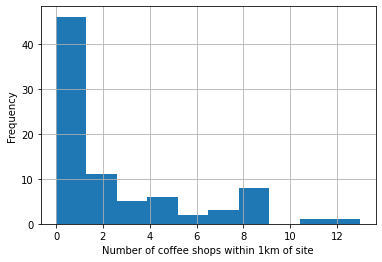

In [19]:
# Number of nearby coffee shops
x2=df_playareas.groupby('Site', axis=0).first()['Number_coffee'].hist()
x2.set_xlabel("Number of coffee shops")
x2.set_ylabel("Frequency")
x2

In [22]:
# Now we want to look at the other venues in the area
other_venues = venues[-venues['Category'].isin(["Café","Coffee Shop"])]
print(other_venues.shape)
other_venues['Category'].value_counts()

(1583, 5)


Pub                              85
Park                             82
Grocery Store                    79
Supermarket                      78
Bar                              75
Hotel                            62
Bakery                           48
Fast Food Restaurant             41
Restaurant                       40
Italian Restaurant               33
Pizza Place                      32
Gastropub                        28
Bus Stop                         23
Fish & Chips Shop                22
French Restaurant                21
Indian Restaurant                21
Pharmacy                         20
Deli / Bodega                    20
Seafood Restaurant               19
Sandwich Place                   19
Gym / Fitness Center             16
Gym                              16
Pool                             15
Theater                          15
Trail                            15
Train Station                    15
Scottish Restaurant              15
Clothing Store              

In [23]:
other_venues_onehot = pd.get_dummies(other_venues[['Category']], prefix="", prefix_sep="")
other_venues_onehot['Site'] = other_venues['Site'] 
# move neighborhood column to the first column
fixed_columns = [other_venues_onehot.columns[-1]] + list(other_venues_onehot.columns[:-1])
other_venues_onehot = other_venues_onehot[fixed_columns]
other_venues_grouped = other_venues_onehot.groupby('Site').mean().reset_index()
other_venues_grouped.head()

,Site,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Campground,Canal,Candy Store,Carpet Store,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food Court,Forest,Fountain,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hill,Historic Site,Home Service,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Locksmith,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Modern European Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Rugby Pitch,Rugby Stadium,Sandwich Place,Scenic Lookout,Science Museum,Scottish Restaurant,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Skate Park,Skating Rink,Smoothie Shop,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfall,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Zoo,Zoo Exhibit
0,Admirality Street,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.000000,0.0,0.02381,0.000000,0.071429,0.0,0.0,0.0,0.0,0.000000,0.02381,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.000000,0.047619,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.02381,0.0,0.0,0.047619,0.000000,0.0,0.0,0.023810,0.0,0.0,0.000000,0.0,0.02381,0.023810,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.023810,0.02381,0.0000,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,0.02381,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.02381,0.0,0.000000,0.047619,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.02381,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02381,0.02381,0.0,0.0,0.0,0.0,0.02381,0.02381,0.000000,0.0,0.000000,0.02381,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.023810,0.000000,0.000000,0.0,0.02381,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.02381,0.02381,0.0,0.0,0.000000,0.000000
1,Allison Park,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.1666

In [51]:
clf=RandomForestRegressor(n_estimators=100,random_state=0)
X=other_venues_grouped.drop(['Site'],axis=1)
y=df_playareas.reset_index()['Number_coffee'].to_numpy()
clf.fit(X,y)
df_playareas['pred_coffee']=clf.predict(X)

In [26]:
# Training performance measures
print("Mean squared error =", round(sm.mean_squared_error(y, df_playareas['pred_coffee']), 2)) 
print("R2 score =", round(sm.r2_score(y, df_playareas['pred_coffee']), 2))

Mean squared error = 0.34
R2 score = 0.96


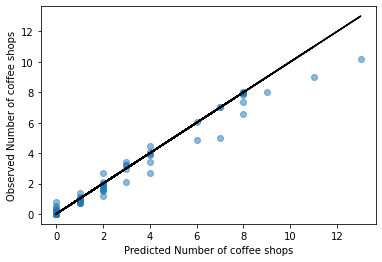

In [45]:
plt.scatter(y, df_playareas['pred_coffee'], alpha=0.5)
plt.xlabel("Predicted Number of coffee shops")
plt.ylabel("Observed Number of coffee shops")
plt.plot(y, y, '-k')

In [52]:
df_playareas['Defecit_coffee']=df_playareas['pred_coffee']-df_playareas['Number_coffee']
df_playareas['Spot'] = df_playareas['Defecit_coffee'].apply(lambda x: 1 if x>0.5 else 0)
df_playareas=df_playareas.reset_index(drop=False)
df_playareas.head()

,Site,Latitude,Longitude,Number_coffee,pred_coffee,Defecit_coffee,Spot
0,Admirality Street,55.97615152741767,-3.1789112091064453,8,7.96,-0.04,0
1,Allison Park,55.95463010760622,-3.410053253173828,0,0.16,0.16,0
2,Ardshiel Avenue (Torrence Park),55.953523,-3.29278,0,0.15,0.15,0
3,Bailie Place (Rear Nos. 1-5),55.943291,-3.111828,0,0.16,0.16,0
4,Balgreen Park,55.94174996445649,-3.2571029663085938,2,1.55,-0.45,0


In [53]:
# Let's see how many potential spots we have identified which have a coffee defecit
pd.crosstab(index=df_playareas['Spot'],  columns="count") 

col_0,count
Spot,
0,80
1,3


In [54]:
good_sites=df_playareas[df_playareas['Spot']==1]
good_sites=good_sites[['Site','Latitude','Longitude']]
good_sites.head()

,Site,Latitude,Longitude
12,Clermiston Park,55.956984595894816,-3.2873153686523438
20,East Pilton Park,55.973702148062415,-3.2271480560302734
28,Granton Crescent,55.979609210714784,-3.2244014739990234


In [59]:
### Reformat this for subsequent merging
good_sites['Location_Type']="Park"

### Keep only the relevent coffee shops
coffee_near_site=coffee_venues.merge(good_sites['Site'],on='Site')
coffee_near_site=coffee_near_site.drop('Site', axis=1)
coffee_near_site=coffee_near_site.rename(columns={'Venue Latitude':'Latitude',
                                                 'Venue Longitude':'Longitude'})
### Merge in their location coffee shops to investigate them
df_merged=good_sites.rename(columns={'Site':'Location'}).append(coffee_near_site)

#Reformat the toilets data
df_toilets=df[['Site','Toilet','Toilet_Location']]
df_toilets[['Latitude','Longitude']]=df_toilets['Toilet_Location'].str.split(',', expand=True)
df_toilets=df_toilets.drop('Toilet_Location', axis=1)
df_toilets=df_toilets.rename(columns={'Toilet':'Location'})
df_toilets['Location_Type']='Toilet'

### Keep only the relevent toilets
df_toilets_near=df_toilets.merge(good_sites['Site'],on='Site')
df_toilets_near=df_toilets_near.drop('Site', axis=1)
df_toilets_near

# Merge this in too
df_merged=df_merged.append(df_toilets_near)
df_merged['type_code'] = df_merged.Location_Type.astype('category').cat.codes
df_merged['Latitude']=df_merged['Latitude'].astype("float") 
df_merged['Longitude']=df_merged['Longitude'].astype("float") 
df_merged

/Applications/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Location,Latitude,Longitude,Location_Type,type_code
12,Clermiston Park,55.956985,-3.287315,Park,1
20,East Pilton Park,55.973702,-3.227148,Park,1
28,Granton Crescent,55.979609,-3.224401,Park,1
0,Starbucks,55.968056,-3.235028,Coffee Shop,0
1,Morrisons Café,55.969796,-3.231701,Coffee Shop,0
0,Ainslie Park Leisure Centre,55.972015,-3.230425,Toilet,2
1,Granton Library,55.976548,-3.226371,Toilet,2
2,Royston Wardieburn\n Community Centre,55.976715,-3.230318,Toilet,2
3,Drumbrae Leisure Centre,55.956166,-3.294246,Toilet,2
4,Drumbrae Library Hub (West Neighbourhood),55.956166,-3.294246,Toilet,2


In [60]:
# create map
map_clusters = folium.Map(location=[55.962014831, -3.2004253895], zoom_start=12)

# set color scheme for the venue types: play area, coffee shop, toilet
rainbow = ['#b51b1b','#1bb5b5','#fcb045']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, label in zip(df_merged['Latitude'], 
                                  df_merged['Longitude'], 
                                  df_merged['Location'], 
                                  df_merged['type_code'],
                                  df_merged['Location_Type']):
    label = folium.Popup(str(label)+ ': ' +str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters